# How to use gnssr4river
___

This notebook is to show what can be done with the gnssr4river python library. The toolbox aims to provide you different data for multiple locations of the receiver, and show you the best place for placing your receiver to perform GNSS reflectometry over a river.

A notebook can be used directly if you want.

*See here:* https://github.com/lroineau/gnssr4river/docs/guideline.ipynb

## Import 
___
First lets start with the useful import.

In [1]:
try:

    #general purpose libraires
    import math
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    import fiona
    import cartopy
    import shapefile
    #visualization libraries
    %matplotlib inline
    import matplotlib.pyplot as plt

    #project modules
    import gnssr4river.fresnel.fresnelzone
    import gnssr4river.fresnel.plotfresnel
    import gnssr4river.fresnel.iterfresnel
    import gnssr4river.fresnel.getorbits
    import gnssr4river.fresnel.geod
    import gnssr4river.fresnel.intersect
    import gnssr4river.refl.nmea
    import gnssr4river.refl.snr

    print('All imports done succesfully')

except ImportError:
    raise ImportError('Fail to import one or more modules')

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.8.0-CAPI-1.13.1). Conversions between both will be slow.
  warnings.warn(


All imports done succesfully


## Finding the reflection point
___

### Satellite orbits

The first step is to know where the reflections will be around your receiver. To have a reflection point, you need to have a **visible satellite** for the azimuth and elevation given, so we need GNSS orbits data to filter our Fresnel zones. To do so, the data from the ESA are downloaded. The function takes the newest files if no date is given. You can see in the output the sp3 file in a DataFrame, it gives coordinates for **GPS** and **GLONASS** satellites. After that, we can calculate the elevation and azimuth of the satellite from the receiver, and this for each satellite of the file. Note that the data covers 2 days, they are available every 6 hours, and give predicted orbits for the coming 24 hours, and the past 24 hours orbits. The choice was made to keep previous orbits, because it gives an idea of where reflections occurred. However, you can also keep only predicted orbits if you want.

In [2]:
orb = retrieve_orbits()
df_sp3 = read_sp3(orb)

display(df_sp3)

GPS week is: 2225
File already exists
_______________________________________________________________________________________
Orbits for GPS and GLONASS satellites from 2022-09-01 06:00:00 to 2022-09-03 05:00:00
_______________________________________________________________________________________


date   system  week       tow             x             y  \
0    2022-09-01 06:00:00      GPS  2225  367200.0  15494.460407   7405.860871   
1    2022-09-01 06:00:00      GPS  2225  367200.0 -13443.044646   8533.065721   
2    2022-09-01 06:00:00      GPS  2225  367200.0 -24534.865753  -9795.447506   
3    2022-09-01 06:00:00      GPS  2225  367200.0  16988.525977 -19889.145607   
4    2022-09-01 06:00:00      GPS  2225  367200.0  -2719.850786 -17539.440842   
...                  ...      ...   ...       ...           ...           ...   
9787 2022-09-03 05:00:00  GLONASS  2225  536400.0   3940.888226  18162.845885   
9788 2022-09-03 05:00:00  GLONASS  2225  536400.0 -21603.361116   8544.595560   
9789 2022-09-03 05:00:00  GLONASS  2225  536400.0   5779.963208 -11602.180062   
9790 2022-09-03 05:00:00  GLONASS  2225  536400.0  -9151.741032   5822.810998   
9791 2022-09-03 05:00:00  GLONASS  2225  536400.0  -3393.276831 -15998.951446   

                 z  prn       clock  
0    -19891.470000   22  319.934551  
1     21061.815220   13  378.959583  
2      1214.583239   28  340.135762  
3       385.255439   21  159.952792  
4     20027.525320    7  310.894812  
...            ...  ...         ...  
9787  17490.915631    5   99.006849  
9788 -10513.693056   15   93.918237  
9789  22003.601125   12   20.781765  
9790  23109.273184    4  156.211169  
9791 -19570.725007   24  112.451962  

[9792 rows x 9 columns]

In [3]:
df_sat = elevazim(df_sp3,7.029344,52.343585,2)
display(df_sat)

# Clean directory of orbits file
clean_dir('Orbits')

PRN  week                date       tow       clock   system  elevation  \
1      13  2225 2022-09-01 06:00:00  367200.0  378.959583      GPS          6   
3      21  2225 2022-09-01 06:00:00  367200.0  159.952792      GPS          6   
4       7  2225 2022-09-01 06:00:00  367200.0  310.894812      GPS         16   
9      15  2225 2022-09-01 06:00:00  367200.0  -32.633176      GPS         12   
10     16  2225 2022-09-01 06:00:00  367200.0 -522.692950      GPS         58   
...   ...   ...                 ...       ...         ...      ...        ...   
9777   13  2225 2022-09-03 05:00:00  536400.0  -26.384127  GLONASS          5   
9786   21  2225 2022-09-03 05:00:00  536400.0 -330.693207  GLONASS         71   
9787    5  2225 2022-09-03 05:00:00  536400.0   99.006849  GLONASS         31   
9789   12  2225 2022-09-03 05:00:00  536400.0   20.781765  GLONASS         41   
9790    4  2225 2022-09-03 05:00:00  536400.0  156.211169  GLONASS         17   

      azimuth  
1          24  
3         243  
4         313  
9          53  
10        199  
...       ...  
9777      344  
9786      315  
9787       72  
9789      309  
9790       18  

[3774 rows x 8 columns]

### Fresnel zones

Now you can give the elevation you want *(for visualization purpose, only 4 elevations can be given)* and the coordinates of the receiver. Lets say we would like to work on the Dinkel river near Enschede. We can get coordinates from Google Maps. **Be aware that Maps gives you coordinates in latitude - longitude, and the function takes longitude - latitude!** 

We can have a look first at the area of the location we would like to put your receiver. You can choose if you want to save the image.

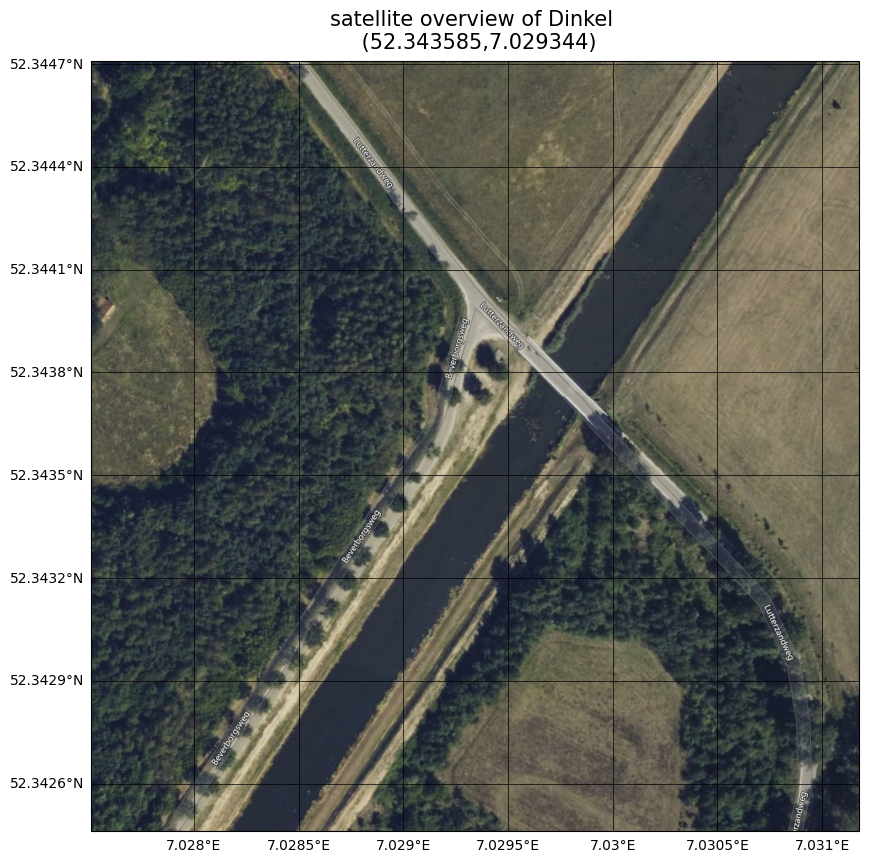

In [4]:
osm_image(7.029344,52.343585,50, sitename='Dinkel',style='satellite',save=False)

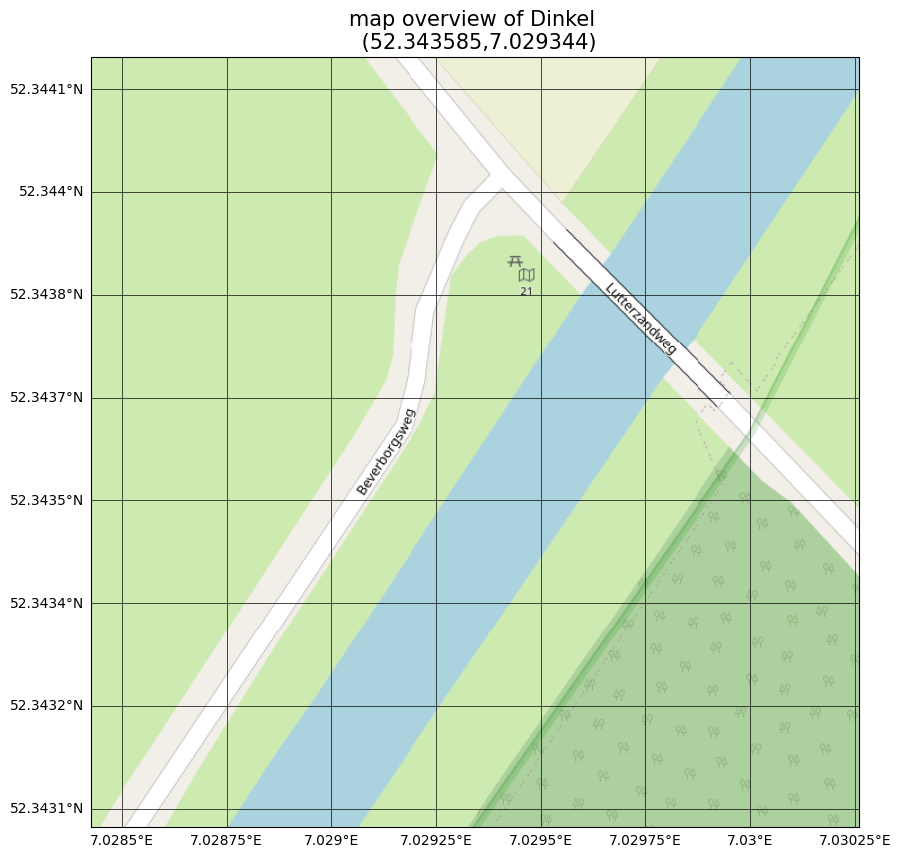

In [5]:
osm_image(7.029344,52.343585,25, sitename='Dinkel',style='map',save=False)

Let's try to get the Fresnel zones for different antenna height so that we can compare later, for example 0.5m, 1m, 1.5m and 2m. As we are performing SNR based reflectometry, **only low elevation angles can be taken**. We will use for calculations 5°, 10° and 15°. 

**Increasing the antenna height will result in larger Fresnel zones, and further from the receiver center.**

You can choose the output format if you want to use the file in **QGIS** for example. Note that the advantage of geopackage is that you only have one file instead of 5 for shapefile! It is then default value.

In [6]:
reflZone(0.5, [5,10,15],7.029344,52.343585)
reflZone(1, [5,10,15],7.029344,52.343585)
reflZone(1.5, [5,10,15],7.029344,52.343585)
reflZone(2, [5,10,15],7.029344,52.343585)

GPS week is: 2225
Data download success
_______________________________________________________________________________________
Orbits for GPS and GLONASS satellites from 2022-09-01 06:00:00 to 2022-09-03 05:00:00
_______________________________________________________________________________________
File Fresnel[5, 10, 15]_0.5.gpkg successfully created in FresnelZones
GPS week is: 2225
File already exists
_______________________________________________________________________________________
Orbits for GPS and GLONASS satellites from 2022-09-01 06:00:00 to 2022-09-03 05:00:00
_______________________________________________________________________________________
File Fresnel[5, 10, 15]_1.gpkg successfully created in FresnelZones
GPS week is: 2225
File already exists
_______________________________________________________________________________________
Orbits for GPS and GLONASS satellites from 2022-09-01 06:00:00 to 2022-09-03 05:00:00
________________________________________________

ID  azimuth  elevation        area  \
0      0        7          5  200.226869   
1      1        8          5  200.226869   
2      2       11          5  200.226869   
3      3       12          5  200.226869   
4      4       18          5  200.226869   
..   ...      ...        ...         ...   
201  201      324         15   19.476232   
202  202      326         15   19.476232   
203  203      343         15   19.476232   
204  204      345         15   19.476232   
205  205      347         15   19.476232   

                                              geometry  
0    POLYGON ((7.02941 52.34392, 7.02941 52.34392, ...  
1    POLYGON ((7.02942 52.34392, 7.02942 52.34392, ...  
2    POLYGON ((7.02945 52.34392, 7.02945 52.34392, ...  
3    POLYGON ((7.02946 52.34392, 7.02946 52.34392, ...  
4    POLYGON ((7.02952 52.34391, 7.02952 52.34391, ...  
..                                                 ...  
201  POLYGON ((7.02927 52.34365, 7.02927 52.34365, ...  
202  POLYGON ((7.02928 52.34365, 7.02927 52.34365, ...  
203  POLYGON ((7.02931 52.34366, 7.02931 52.34366, ...  
204  POLYGON ((7.02931 52.34366, 7.02931 52.34366, ...  
205  POLYGON ((7.02932 52.34366, 7.02932 52.34366, ...  

[206 rows x 5 columns]

In this file are stored:
- an ID for each ellipse
- the azimuth
- the elevation 
- the area in m2
- the geometry of the ellipse

Now that we have created the files of our Fresnel zones, we can plot them with a satellite background.

No file for waterbody given


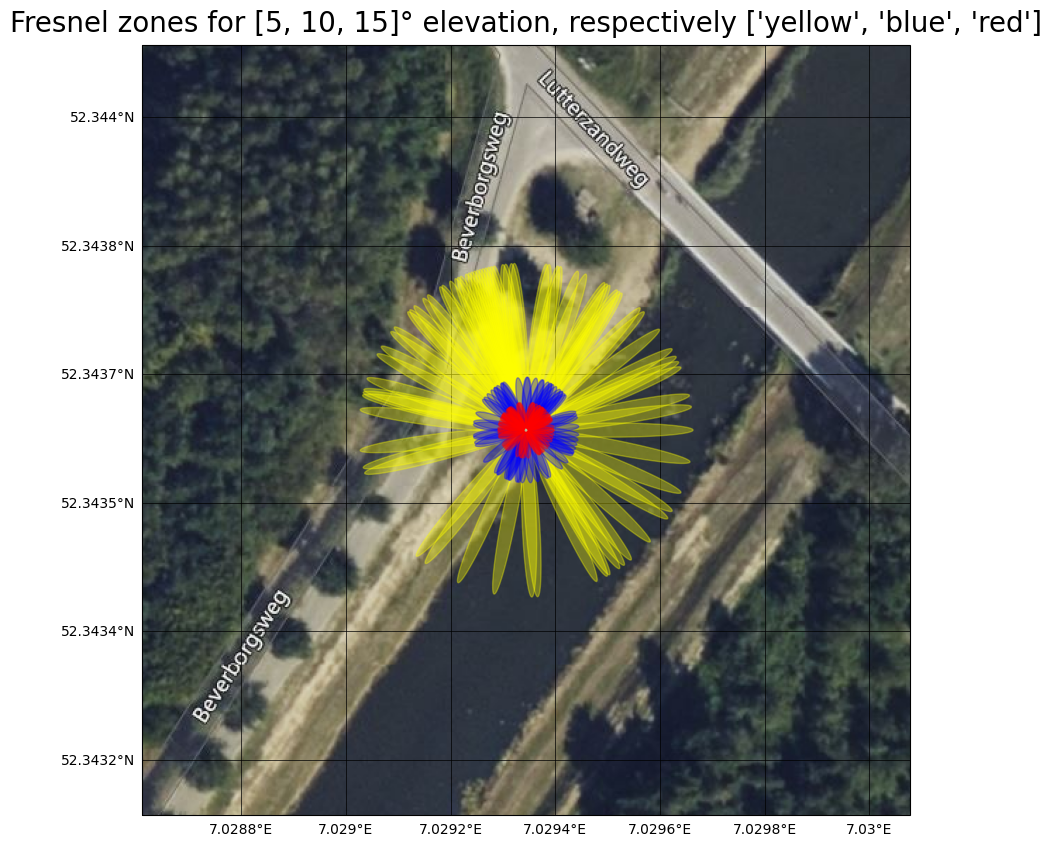

In [7]:
fresnelMap(7.029344,52.343585,dist=20,filezone='FresnelZones/Fresnel[5, 10, 15]_0.5.gpkg')

No file for waterbody given


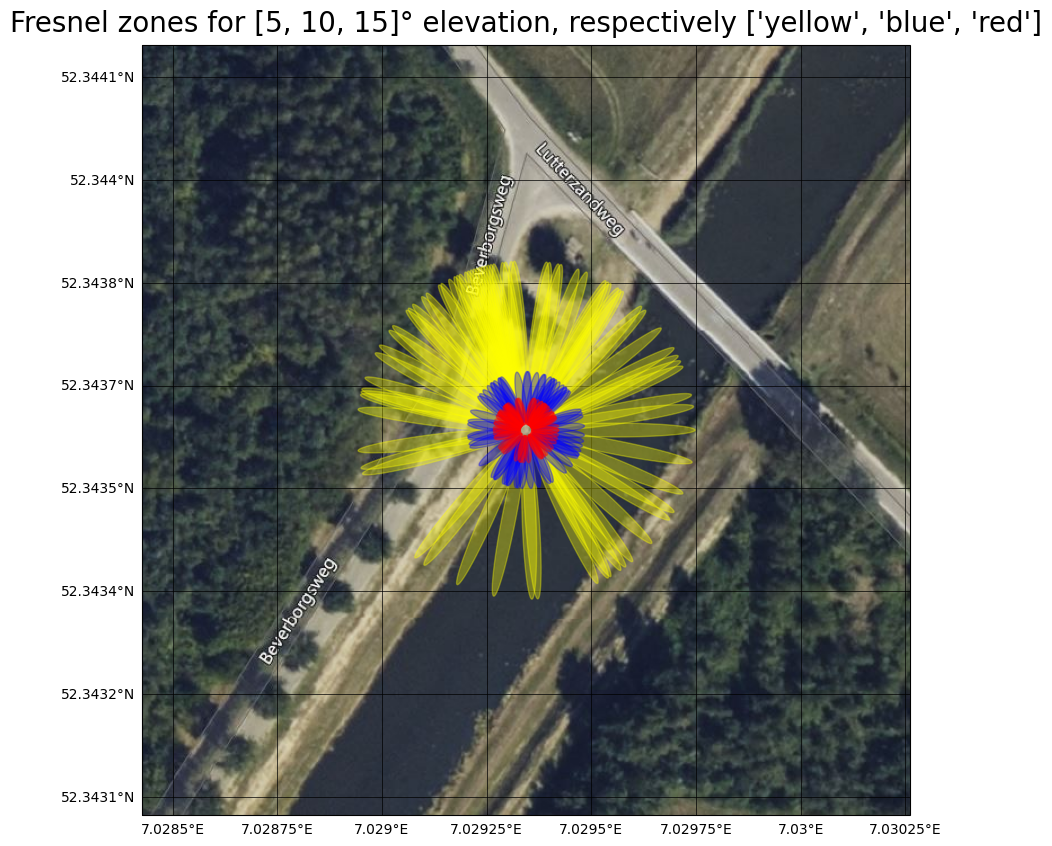

In [8]:
fresnelMap(7.029344,52.343585,dist=25,sitename=None,filezone='FresnelZones/Fresnel[5, 10, 15]_1.gpkg')

### Adding an azimuth mask

You can also add a custom azimuth mask. Minimum can be superior to maximum in case the mask contains values from each side near azimuth 0.

No file for waterbody given


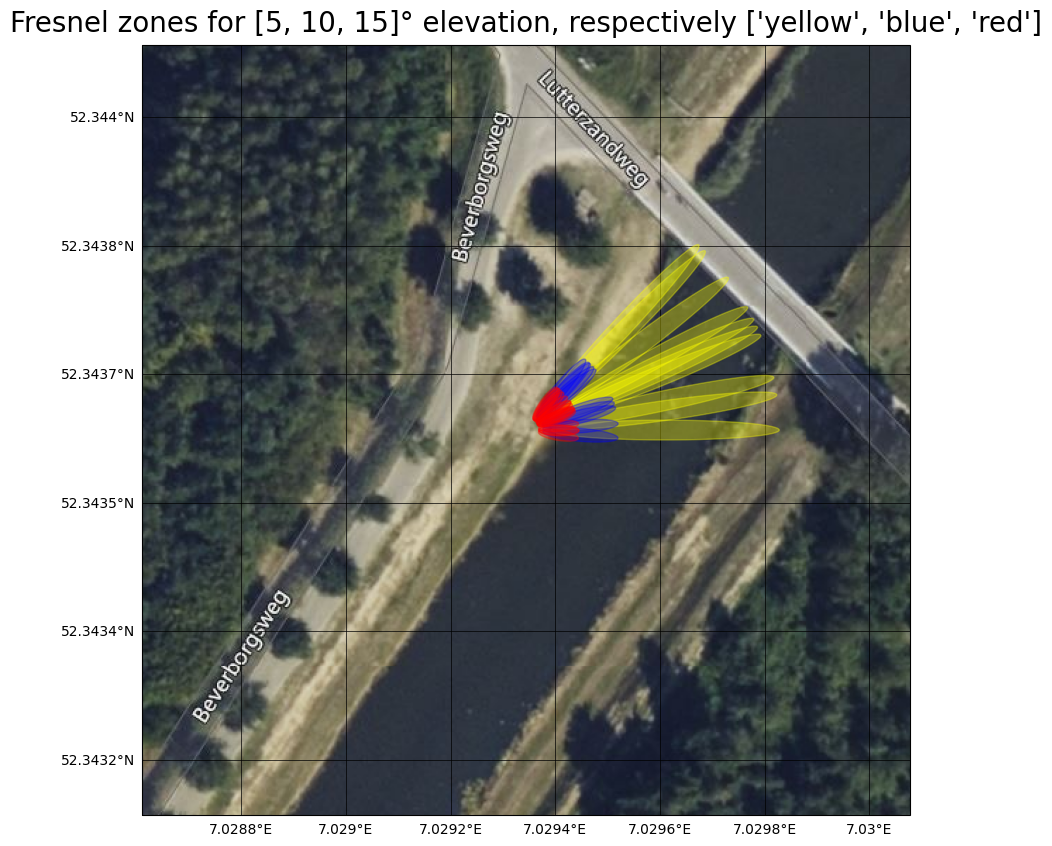

In [9]:
fresnelMap(7.029344,52.343585,dist=20,sitename=None,filezone='FresnelZones/Fresnel[5, 10, 15]_1.5.gpkg',azmin=35,azmax=100)

For this last one, we can also show the nearest altimeter track from a Sentinel 3 satellite. It can be useful if you want to set your antenna close to an altimeter track. Just set alti to True. 

No file for waterbody given


/usr/local/lib/python3.8/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/usr/local/lib/python3.8/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


Nearest altimeter track from Sentinel 3 satellites is at 11.594 km
________________________________



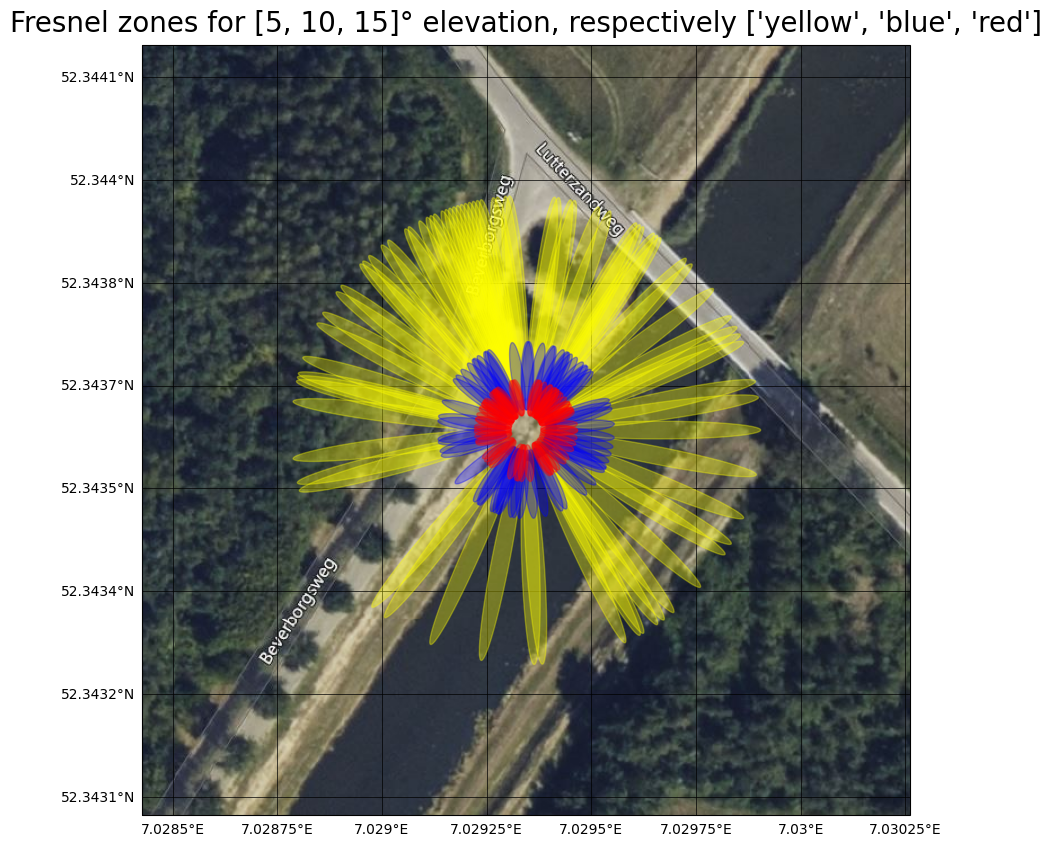

In [10]:
fresnelMap(7.029344,52.343585,dist=25,sitename=None,filezone='FresnelZones/Fresnel[5, 10, 15]_2.gpkg',alti=True)

## Intersection with the river
___
**This part is only if you have a file of the water body**

We would like to see if the reflection points we have intersect the river where the measurements would be made. That way, we can produce azimuth masks and only keep the reflection points of the area of interest. The production of the azimuth mask is automatic, and the algorithm also return the number of Fresnel zones that are completely within the water body. This is used to compare between different antenna height. This means that you are certain to have this number of reflection points in the river. The oth

*Keep in mind that even if you are giving a file for the water body, you still have to pay attention to the quality of the file. Here for example, one can see that it is not perfect and thus the algorithm is missing potential reflection points in the intersection.*

Window of observation:
Azimuth between 33° and 204°
Number of Fresnel zones completely within water body is 11


/tmp/ipykernel_842/4052113299.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  fresnelMap(7.029344,52.343585,dist=20,sitename=None,filezone='FresnelZones/Fresnel[5, 10, 15]_1.gpkg',filewb='private/Olmeidingskanaal_WGS84.shp',save=True)


(11, [(33, 204)])

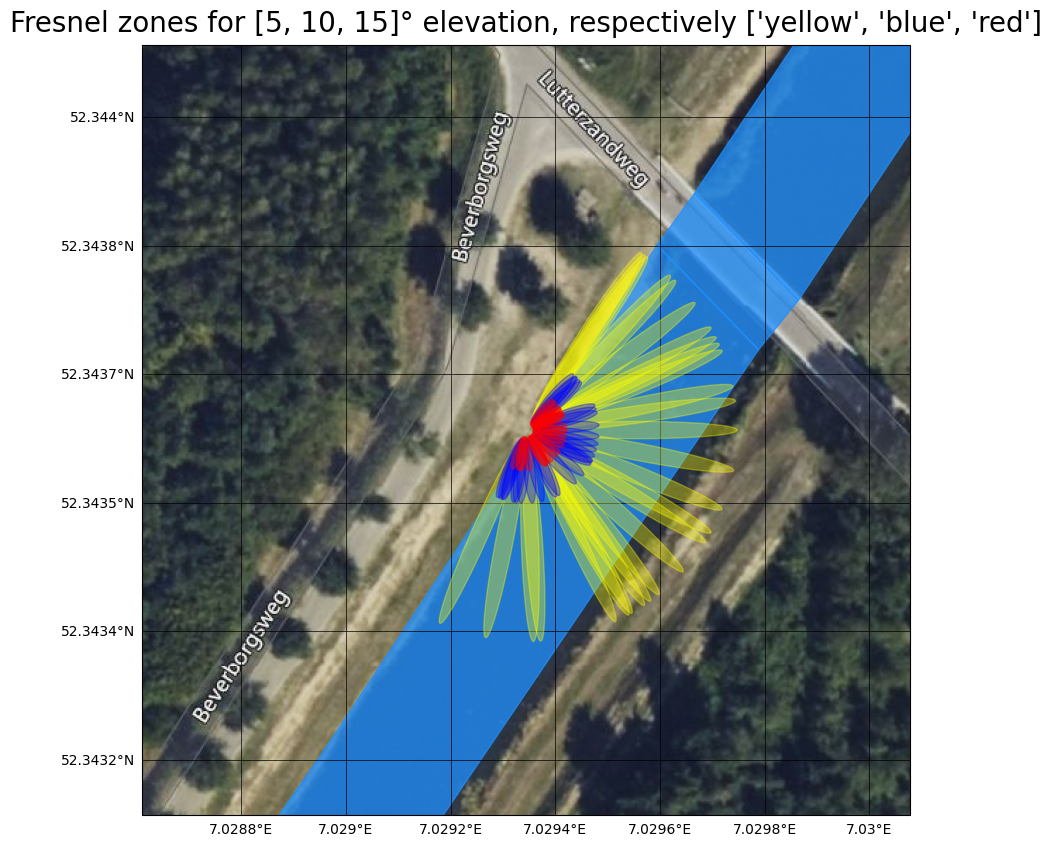

In [11]:
fresnelMap(7.029344,52.343585,dist=20,sitename=None,filezone='FresnelZones/Fresnel[5, 10, 15]_1.gpkg',filewb='private/Olmeidingskanaal_WGS84.shp',save=True)

### Analysis of the results
___
**This part details results obtained from a test survey and should be taken with caution. You should check carefully check the results from your survey. Functions below are not 100% sure.**

If you had a successful survey, and retrieved a nmea file of you observations, first thing to do is to read the nmea file. Here it is a file from observations with the spot previously shown.

In [12]:
dataf=r"private/Dinkel_omleidingskanaal20220729.nmea"
df=readnmea(dataf)
#get rid of nan's
df=df.loc[df.snr.notna()]

display(df)

lat       lon  elev     az  \
time                system  PRN segment                                     
2022-07-29 08:52:15 GPS     27  0        52.343575  7.029408  86.0  280.0   
                            10  0        52.343575  7.029408  55.0  133.0   
                            23  1        52.343575  7.029408  50.0   77.0   
                            8   0        52.343575  7.029408  44.0  294.0   
                            16  1        52.343575  7.029408  43.0  190.0   
...                                            ...       ...   ...    ...   
2022-07-29 13:38:40 GLONASS 83  27       52.343608  7.029412  32.0  152.0   
                            85  4        52.343608  7.029412  19.0  324.0   
                            77  0        52.343608  7.029412  12.0   38.0   
                            76  1        52.343608  7.029412  11.0  351.0   
                            67  1        52.343608  7.029412   7.0   44.0   

                                          snr   elevsmth      azsmth  
time                system  PRN segment                               
2022-07-29 08:52:15 GPS     27  0        30.0  85.589744  283.282051  
                            10  0        42.0  54.393443  133.702703  
                            23  1        44.0  50.567568   77.800000  
                            8   0        33.0  43.648649  294.795699  
                            16  1        41.0  43.368421  190.285714  
...                                       ...        ...         ...  
2022-07-29 13:38:40 GLONASS 83  27       21.0  31.892857  152.057692  
                            85  4        31.0  19.500000  324.232558  
                            77  0        30.0  12.051948   37.866667  
                            76  1        38.0  10.838150  350.866667  
                            67  1        37.0   6.892857   44.357616  

[68246 rows x 7 columns]

First, let's have a look to the SNR data for each satellite in our window of observations. Here because of the orientation of the antenna, we will take observations between 160° and 210°. This way we can know which measure can be used. We can consider that a measure is suitable if the SNR with respect to time follows a polynomial trend for low elevation angle (like PRN16 or PRN69 for example).

*Plot is not readable directly in the notebook, do not hesitate to download it for a better view. It is meant to help you have a global view of the results.* 

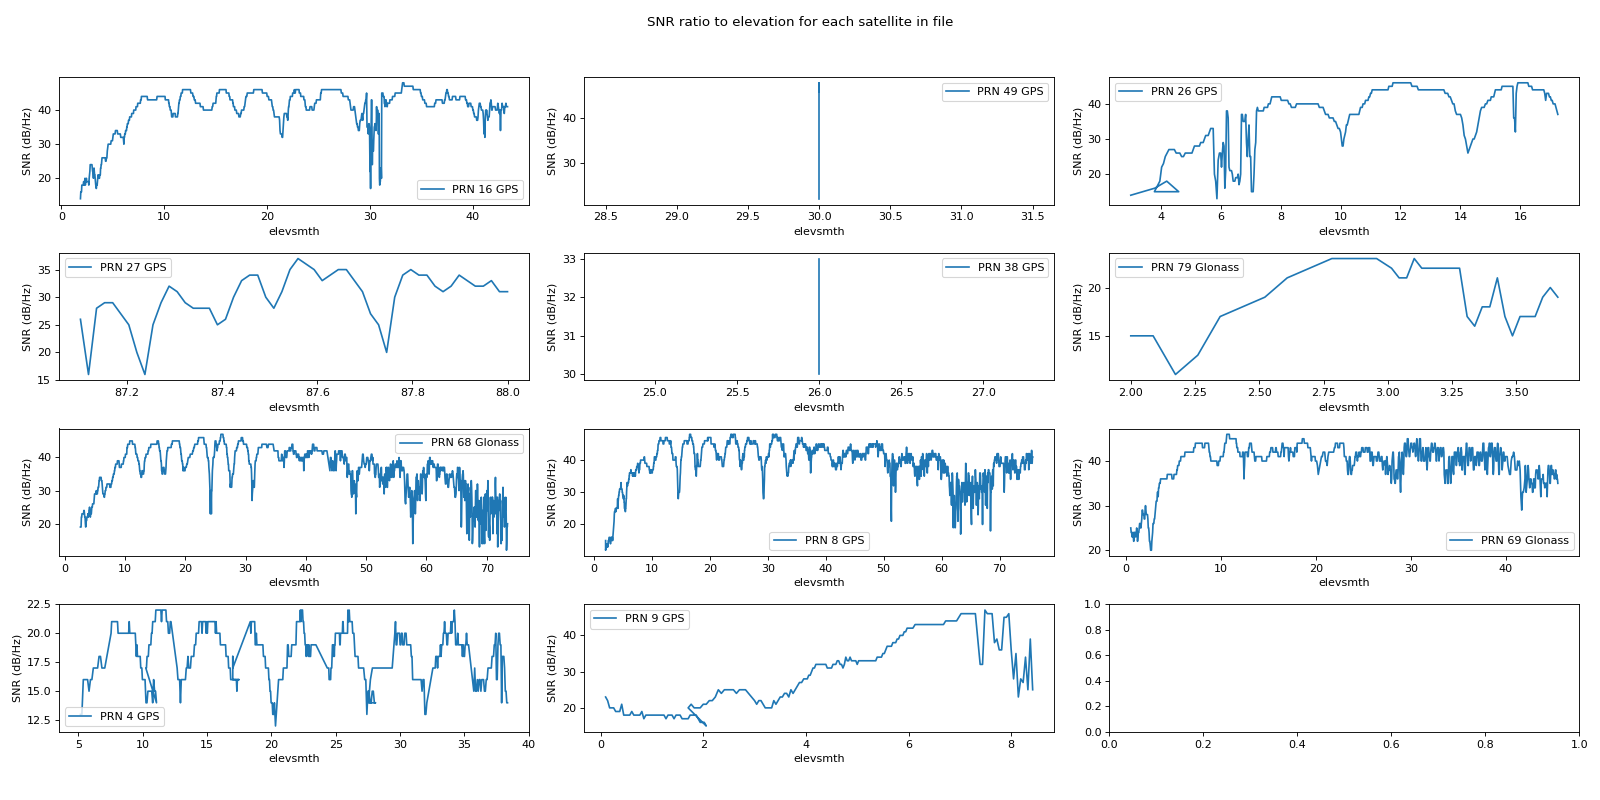

In [13]:
%matplotlib ipympl
plotSnr(df, azrange=[160,210], xaxis=0, show=True, save=False)

___
*Despite having some observations which look promising, they do not all return consistent values. Here again, be careful with results. You should always check if they are around the expected value.*
___

For the analysis part, we will use the dissertation from Clara Chew (available here: https://cires1.colorado.edu/portal/publications/ClaraChew_dissertation.pdf). 

This is the data processing for getting from SNR data to reflector height:
- In order to remove the influence of the direct signal and only see the interference pattern, the SNR is first converted to a linear scale in volt/volt.
- The sinus of the elevation is calculated, and is used rather than the elevation.
- Following this conversion the signal is detrended with a low order polynomial. Because the SNR correspond to the sum of the direct signal and the reflected signal, removing this trend allows to keep only the reflected contribution.
- As data above 30° elevation angle contain no significant oscillations due to multipath, they are discarded from the remaining SNR series.
-  It is then possible, using a Lomb-Scargle Periodogram (LSP), to determine the height by finding the highest peak of the LSP result (Fig. For more information on the LSP and the result analysis, see Appendix D.

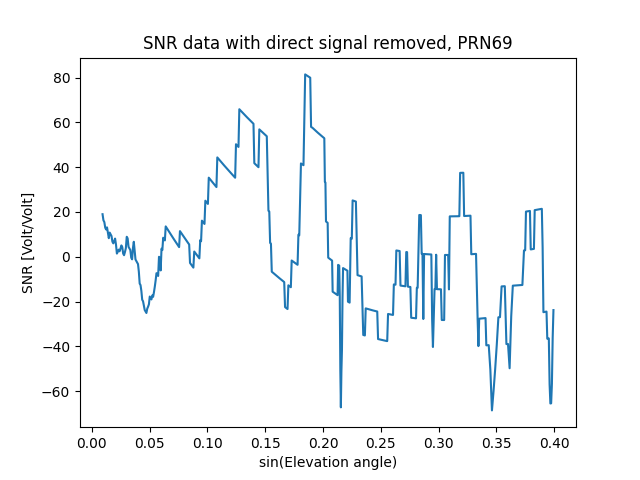

In [18]:
dfd69=detrende_signal(df,69,order=4)
%matplotlib ipympl
plot_detrende(dfd69,69)

Here you can already see that the detrended signal does not look really good. So you should not expect a good result.

Regarding the LSP, you need to give a window of expected height. This allows to remove values that would make no sense. Here for example, knowing the height of our antenna was around 1m30, we will say the window is between 0 and 6 to have enough values for the LSP.

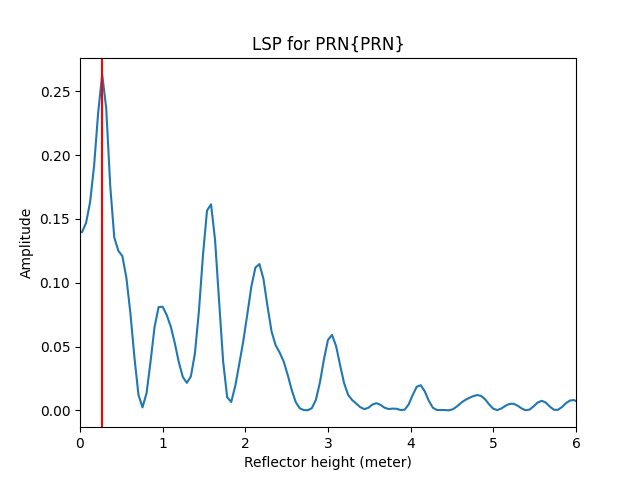

In [19]:
%matplotlib ipympl
frequency,height,maxF,maxAmp=height_LSP(dfd69,0,6,69)

For this LSP, the value of the largest spike is not really what we expected. In fact, true value would be closer to the second largest spike.

To highlight a good result, we will take the example of data that are not on the river surface, but on the river bank. You can also change the order of the polynomial trend to remove in order to have the best fit.

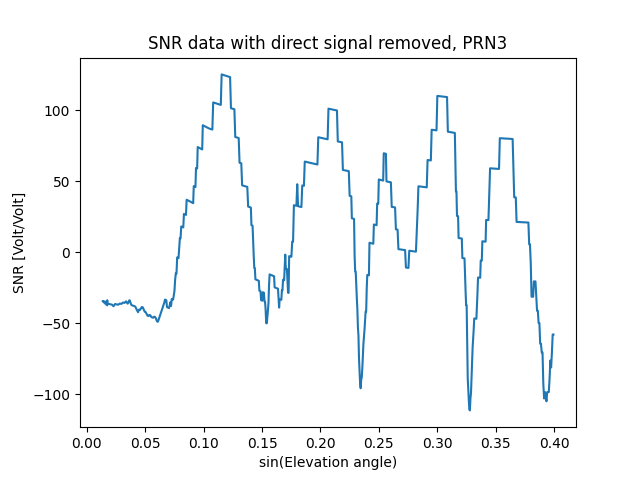

In [20]:
dfd3=detrende_signal(df,3,order=3)
%matplotlib ipympl
plot_detrende(dfd3,3)

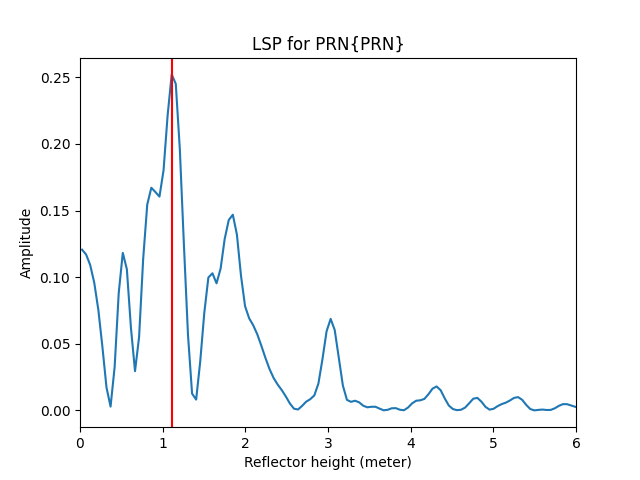

In [21]:
%matplotlib ipympl
frequency,height,maxF,maxAmp=height_LSP(dfd3,0,6,3)

The receiver was placed at a height of 1m09 above the river banks, which were relatively flat. This result is then a really good start.

**Note that to draw real conclusion, one should do many more observations and statistics on them**.

## Author

* **Lubin Roineau** [lubin_roineau](https://github.com/lroineau/)